In [1]:
import kqc_custom
import pandas as pd
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit import Aer,IBMQ
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import winsound
import time

In [2]:
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

In [3]:
provider = IBMQ.load_account()
provider_real = IBMQ.get_provider(hub='ibm-q-kqc', group='internal', project='default')

In [4]:
def qaoa(x,y,gamma) :
    # gamma = default로 2 ? 1로?
    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    p = data_x.shape[1]
    Q = np.abs(data_x.corr())
    for i in range(p) : Q.iloc[i,i] = 0 
    r_squared_list=partial_r1(data_x,data_y)
    
    beta_new =  -Q.apply(sum,axis=1) -2*r_squared_list
    result_qaoa=kqc_custom.qubo_qaoa(Q,beta_new,backend)
    return(result_qaoa)

def qubo_qaoa(Q,beta,backend = Aer.get_backend("qasm_simulator")):
    algorithm_globals.massive = True
    p = Q.shape[0]
    mod = QuadraticProgram("my problem")
    linear = {"x"+str(i): beta[i] for i in range(p)}
    quadratic = {("x"+str(i),"x"+str(j)): Q.values[i,j] for i in range(p) for j in range(p)}

    for i in range(p) :
        mod.binary_var(name="x"+str(i))

    mod.minimize(linear=linear,quadratic=quadratic)
    quantum_instance = QuantumInstance(backend)
    mes = QAOA(quantum_instance=quantum_instance)
    optimizer = MinimumEigenOptimizer(mes)
    result = optimizer.solve(mod)
    return([result,mod])

def mse(X,y):
    q = X.shape[0]
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    mse = np.matmul(np.matmul(y.T,(np.identity(q)-proj)),y)/q
    return(mse)

def cn(X): 
    if X.shape[1]==1 : return(1)
    cordata = np.corrcoef(X.T)
    eig_value = np.linalg.eig(cordata)[0]
    return(np.max(eig_value)/np.min(eig_value))

def projection(X):
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    return(proj)
    
def partial_r1(X,y):
    X = np.asarray(X);y=np.asarray(y).reshape((-1))
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1))
    q=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,q):
        ind = [i for i in range(i)] + [i for i in range(i+1,q)]
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,ind]))),y)
        partial_r_list += [1-SSRF/SSRR]
    return(np.array(partial_r_list))

def partial_r2(X,y):
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1)) ; y = np.asarray(y)
    p=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,p):
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,[0,i]]))),y)
        partial_r_list += [SSRF/SSRR]
    return(np.array(partial_r_list))

In [17]:
X,y = kqc_custom.generate_dependent_sample(500,5,beta_coef=[4, 3, 2 , 2],epsilon=4,covariance_parameter=12)

In [18]:
np.corrcoef(X.T)

array([[ 1.        , -0.52523349,  0.12458555, -0.75836118, -0.40161095],
       [-0.52523349,  1.        ,  0.5135643 ,  0.87226772,  0.80311677],
       [ 0.12458555,  0.5135643 ,  1.        ,  0.43565491,  0.4220807 ],
       [-0.75836118,  0.87226772,  0.43565491,  1.        ,  0.5637588 ],
       [-0.40161095,  0.80311677,  0.4220807 ,  0.5637588 ,  1.        ]])

In [19]:
# Qasm 시뮬레이터/Real_device 사용시
# backend = provider_real.get_backend("ibmq_qasm_simulator")

# 로컬 시뮬레이터 사용시
backend =Aer.get_backend('qasm_simulator')

<ipython-input-20-7c94d5e8d241>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(141)
<ipython-input-20-7c94d5e8d241>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(142)
<ipython-input-20-7c94d5e8d241>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

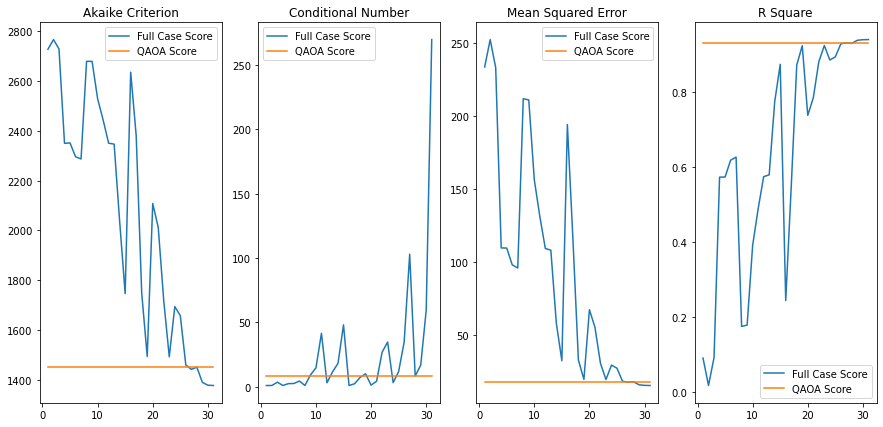

In [20]:
n = X.shape[0]
p = X.shape[1]
mse_list = []
rsquare_list =[]
aic_list = []
cn_list = []
for i in range(1,2**p):
    binind = [bool(int(j)) for j in bin(i)[2:]]
    binind = [False for i in range(p-len(binind))]+ binind
    X_choose = X[:,binind]
    q = X_choose.shape[1]
    mse_temp = mse(X_choose,y)
    cn_list  += [cn(X_choose)]
    mse_list += [mse_temp]
    rsquare_list += [1-mse_temp/np.var(y)]
    aic_list += [2*q+n*np.log(mse_temp)]
    
plt.figure(figsize = (15,7))
plt.subplot(141)
plt.plot([i for i in range(1,2**p)],aic_list,label = "Full Case Score")
plt.subplot(142)
plt.plot([i for i in range(1,2**p)],cn_list,label = "Full Case Score")
plt.subplot(143)
plt.plot([i for i in range(1,2**p)],mse_list,label = "Full Case Score")
plt.subplot(144)
plt.plot([i for i in range(1,2**p)],rsquare_list,label = "Full Case Score")


start_time = time.time()

result = qaoa(X,y,2)
qaoa_ind = [bool(i) for i in result[0]]
X_choose = X[:,qaoa_ind]
mse_qaoa = mse(X_choose,y)
aic_qaoa = 2*sum(qaoa_ind)+n*np.log(mse_qaoa)
rsquare_qaoa = 1-mse_qaoa/np.var(y)
cn_qaoa  = cn(X_choose)

plt.subplot(141)
plt.plot([i for i in range(1,2**p)],[aic_qaoa for i in range(1,2**p)],label = "QAOA Score")
plt.legend()
plt.title("Akaike Criterion")
plt.subplot(142)
plt.plot([i for i in range(1,2**p)],[cn_qaoa for i in range(1,2**p)],label = "QAOA Score")
plt.legend()
plt.title("Conditional Number")
plt.subplot(143)
plt.plot([i for i in range(1,2**p)],[mse_qaoa for i in range(1,2**p)],label = "QAOA Score")
plt.legend()
plt.title("Mean Squared Error")
plt.subplot(144)
plt.plot([i for i in range(1,2**p)],[rsquare_qaoa for i in range(1,2**p)],label = "QAOA Score")
plt.legend()
plt.title("R Square")

plt.show()

In [14]:
print((time.time() - start_time))
winsound.Beep(frequency, duration)

2.2800941467285156


In [446]:
X,y = kqc_custom.generate_dependent_sample(500,10,beta_coef=[4, 3, 2 , 2],epsilon=4,covariance_parameter=2)

In [447]:
# Qasm 시뮬레이터/Real_device 사용시
#backend = provider_real.get_backend("ibmq_qasm_simulator")

# 로컬 시뮬레이터 사용시
backend =Aer.get_backend('qasm_simulator')

<ipython-input-448-0d2bec8b5590>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(141)
<ipython-input-448-0d2bec8b5590>:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(142)
<ipython-input-448-0d2bec8b5590>:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

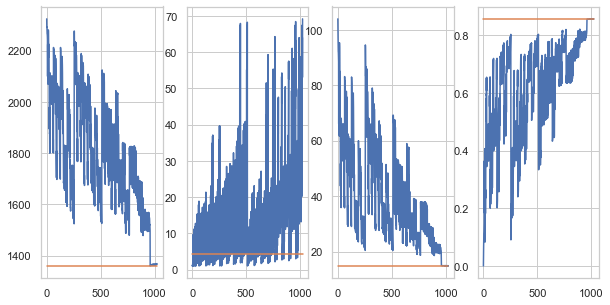

In [448]:
n = X.shape[0]
p = X.shape[1]
mse_list = []
rsquare_list =[]
aic_list = []
cn_list = []
for i in range(1,2**p):
    binind = [bool(int(j)) for j in bin(i)[2:]]
    binind = [False for i in range(p-len(binind))]+ binind
    X_choose = X[:,binind]
    q = X_choose.shape[1]
    mse_temp = mse(X_choose,y)
    cn_list  += [cn(X_choose)]
    mse_list += [mse_temp]
    rsquare_list += [1-mse_temp/np.var(y)]
    aic_list += [2*q+n*np.log(mse_temp)]
plt.figure(figsize = (10,5))
plt.subplot(141)
plt.plot([i for i in range(1,2**p)],aic_list)
plt.subplot(142)
plt.plot([i for i in range(1,2**p)],cn_list)
plt.subplot(143)
plt.plot([i for i in range(1,2**p)],mse_list)
plt.subplot(144)
plt.plot([i for i in range(1,2**p)],rsquare_list)


start_time = time.time()

result = qaoa(X,y,2)
qaoa_ind = [bool(i) for i in result[0]]
X_choose = X[:,qaoa_ind]
mse_qaoa = mse(X_choose,y)
aic_qaoa = 2*sum(qaoa_ind)+n*np.log(mse_qaoa)
rsquare_qaoa = 1-mse_qaoa/np.var(y)
cn_qaoa  = cn(X_choose)
plt.subplot(141)
plt.plot([i for i in range(1,2**p)],[aic_qaoa for i in range(1,2**p)])
plt.subplot(142)
plt.plot([i for i in range(1,2**p)],[cn_qaoa for i in range(1,2**p)])
plt.subplot(143)
plt.plot([i for i in range(1,2**p)],[mse_qaoa for i in range(1,2**p)])
plt.subplot(144)
plt.plot([i for i in range(1,2**p)],[rsquare_qaoa for i in range(1,2**p)])

plt.show()

In [449]:
print((time.time() - start_time))
winsound.Beep(frequency, duration)

10.586701393127441


In [450]:
aic_thre = 1440
high_list = np.array([i for i in range(1,2**p)])[np.array(aic_list)<aic_thre]
high_index = pd.DataFrame([[int(k) for k in bin(j)[2:]] for j in high_list])

In [451]:
high_index.apply(sum,axis=0)

0    64
1    64
2    64
3    64
4    32
5    32
6    32
7    32
8    32
9    32
dtype: int64

In [452]:
r_squared_list=np.array([np.corrcoef(y.T,pd.DataFrame(X).iloc[:,i].T)[1,0]**2 for i in range(p)])

In [453]:
r_squared_list

array([3.34284717e-01, 9.10276668e-02, 2.01987216e-01, 2.00918351e-01,
       3.46652131e-01, 8.33501973e-02, 1.51005744e-01, 9.76213234e-02,
       6.44536224e-02, 3.04144938e-05])

In [454]:
rsquare_compare = pd.DataFrame([partial_r1(X,y),partial_r2(X,y)])
rsquare_compare.columns = ["x" + str(i+1) for i in range(X.shape[1])]
rsquare_compare.index = ["Partial R^2","Simple R^2"]
rsquare_compare = rsquare_compare

In [455]:
rsquare_compare

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
Partial R^2,0.274326,0.207405,0.201993,0.231387,0.003234,0.001211,0.004728,0.000073,0.001933,0.006013
Simple R^2,0.213476,0.156346,0.178085,0.177847,0.217517,0.155036,0.167391,0.157488,0.151905,0.142118


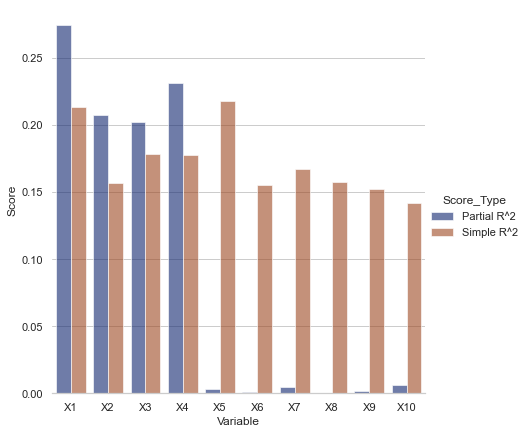

In [463]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plotdf = partial_r1(X,y)
plotdf = pd.DataFrame(np.append(plotdf,partial_r2(X,y)))
plotdf.columns = ["Score"]
plotdf["Variable"] = ["X" + str(i+1) for i in range(p)] + ["X" + str(i+1) for i in range(p)]
plotdf["Score_Type"] =["Partial R^2" for i in range(p)]+["Simple R^2" for i in range(p)]


g = sns.catplot(
    data=plotdf, kind="bar",
    x="Variable", y="Score", hue="Score_Type", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
plt.show()